# Interface Demonstration Notebook

A notebook to demonstrate an interface with some of the features of the Probability of Failure Model

Author: gavin.treseder@essentialenergy.com.au

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import logging
logging.getLogger().setLevel(logging.INFO)

import copy
import multiprocessing as mp

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import plotly.express as px
import plotly.graph_objects as go
from jupyter_dash import JupyterDash

from config import config
from pof.loader.asset_model_loader import AssetModelLoader
from pof import Component, FailureMode, Task
from pof.interface.dashlogger import DashLogger
from pof.interface.layouts import *
from pof.interface.figures import update_condition_fig, update_cost_fig, update_pof_fig, make_inspection_interval_fig

In [2]:
comp = Component.demo()
fm = FailureMode.demo()

In [3]:
# # Turn off logging
# logging.getLogger().setLevel(logging.INFO)
# config['Load']['on_error_use_default'] ='False'

# filename = os.path.dirname(os.getcwd()) + r"\data\inputs\Asset Model - Demo.xlsx"

# aml = AssetModelLoader(filename)
# comp_data = aml.load()
# comp = Component.from_dict(comp_data['pole'])

In [4]:
# Component layout
mcl = make_component_layout(comp)
mfml = make_failure_mode_layout(fm)

var_to_scale = cf.scaling

validate_layout(comp, mcl)

True

In [ ]:

# Turn off logging level to speed up implementation
logging.getLogger().setLevel(logging.CRITICAL)

# Build App
external_stylesheets = [dbc.themes.BOOTSTRAP]
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

comp = Component.demo()
pof_sim = copy.copy(comp)
sens_sim = copy.copy(comp)

mcl = make_component_layout(comp)
validate_layout(comp, mcl)

# Layout
app.layout = html.Div([
    html.Div(id='log'),
    html.Div(children='Update State:', id='update_state'),
    html.Div(children='Sim State', id='sim_state'),
    html.Div(children='Fig State', id='fig_state'),
    html.Div([
        dcc.Input(id='n_iterations-input', value=1, type='number'),
        dcc.Interval(id="progress-interval", n_intervals=0, interval=500),
        dbc.Progress(id="progress"),
    ]),
    dbc.Row(
        [
            dbc.Col(dcc.Graph(id='pof-fig')),
            dbc.Col(dcc.Graph(id='insp_interval-fig')),
        ]
    ),
        dbc.Row(
        [
            dbc.Col(dcc.Graph(id='cond-fig')),
            dbc.Col(dcc.Graph(id="cost-fig"))
        ]
    ),

    mcl,
])


ms_fig_update = comp.get_dash_ids()
param_inputs = [Input(dash_id,"checked") if 'active' in dash_id else Input(dash_id,"value") for dash_id in ms_fig_update]

collapse_ids = comp.get_objects()

@app.callback(
    [Output(f"{prefix}-collapse", "is_open") for prefix in collapse_ids],
    [Input(f"{prefix}-collapse-button", "n_clicks") for prefix in collapse_ids],
    [State(f"{prefix}-collapse", "is_open") for prefix in collapse_ids],
)
def toggle_collapses(*args):
    ctx = dash.callback_context

    state_id = ""
    collapse_id = ctx.triggered[0]['prop_id'].split('.')[0].replace('-collapse-button','')
    if collapse_id in collapse_ids: #TODO change to is not None

        state_id = collapse_id + '-collapse.is_open'
        ctx.states[state_id] = not ctx.states[state_id]

    is_open = tuple(ctx.states.values())

    return is_open

@app.callback(
    Output('update_state', 'children'), 
    param_inputs
)
def update_parameter(graph_y_limit_active, graph_y_limit, *args):

    # Check the parameters that changed
    ctx = dash.callback_context
    dash_id = None
    value=None  

    # If any parameters have changed update the objecte
    if ctx.triggered:
        dash_id = ctx.triggered[0]['prop_id'].split('.')[0]
        value = ctx.triggered[0]['value']

        # Scale the value if req
        value = value / var_to_scale.get(dash_id.split('-')[-1], 1)

        # update the model
        comp.update(dash_id, value)
    
    return f"Update State: {dash_id} - {value}"



@app.callback(
    [Output("sim_state", 'children')],
    [Input("n_iterations-input", "value"), Input("update_state", "children")],
)
def update_n_iterations(n_iterations, *args):
    global pof_sim
    pof_sim.cancel_sim()
    pof_sim = copy.copy(comp)
    pof_sim.next_sim(t_end=200, n_iterations=10)
    return f"Sim State: {pof_sim.n_iterations}"

@app.callback(
    [Output("cost-fig", "figure"),
    Output("pof-fig", "figure"),
    Output("cond-fig", "figure")], 
    [Input("sim_state", "children")]
)
def update_figures(*args):
    cost_fig = update_cost_fig(pof_sim) #legend = dropdown value
    pof_fig = update_pof_fig(pof_sim)
    cond_fig = update_condition_fig(pof_sim)

    return cost_fig, pof_fig, cond_fig

@app.callback(
    [, 
    [Input("sim_state", "children")]
)
def update_figures(*args):
    cost_fig = update_cost_fig(pof_sim) #legend = dropdown value
    pof_fig = update_pof_fig(pof_sim)
    cond_fig = update_condition_fig(pof_sim)

    return cost_fig, pof_fig, cond_fig


@app.callback(
    [Output("progress", "value"), Output("progress", "children")],
    [Input("progress-interval", "n_intervals")],
)
def update_progress(n):
    if comp.n is None:
        raise Exception("no process started")
    progress = int(comp.n / comp.n_iterations * 100)
    # only add text after 5% progress to ensure text isn't squashed too much
    return progress, f"{progress} %" if progress >= 5 else ""


# @app.callback(
#     Output("insp_interval-fig", "figure"), 
#     param_inputs + [Input('cost-fig', 'mcchildren')]
# )
# def update_insp_interval(*args):

#     # Check the parameters that changed
#     ctx = dash.callback_context

#     # If any parameters have changed update the objecte
#     if ctx.triggered:
#         dash_id = ctx.triggered[0]['prop_id'].split('.')[0]
#         value = ctx.triggered[0]['value']

#         # Scale the value if req
#         value = value / var_to_scale.get(dash_id.split('-')[-1], 1)

#         # update the model
#         comp.update(dash_id, value)

#     # Simulate an outcome
#     local = copy.deepcopy(comp)

#     insp_interval_fig = make_inspection_interval_fig(local, t_min=0, t_max=10, step=1, n_iterations = 100)

#     return insp_interval_fig

#app.run_server(debug=False, mode='inline')
app.run_server(debug=True, use_reloader=False)

In [ ]:
pof_sim = copy.copy(comp)

In [7]:
pof_sim.cancel_sim()
pof_sim = copy.copy(comp)
pof_sim.next_sim(t_end=200)

In [26]:
comp.reset()

In [30]:
pof_sim.fm['random'].timeline

{}

In [9]:
df = comp.sensitivity(
    var_name='comp-task_group_name-groundline-t_interval',
    conf=0.9,
    lower=2,
    upper=4,
    n_increments=3,
    n_iterations=10000,
)

False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False]), 2568892578352: array([125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125,
       125, 125, 125, 125, 125, 125, 125, 125, 125, 125]), 2568892578432: array([250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250,
       250, 250, 250, 250, 250, 250, 250, 250, 250, 250]), 2568892578512: array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4]), 2568892578592: array([5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 5,
       4]), 2568892578672: array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1]), 2568892578752: array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1]), 2568892578832: array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [ ]:
# Update the components

# Set n_iterations to 1
# Loop
    # Multiply by 10
    # Create the graphs


# Set n_iterations to 1
# While no interupt:
    # If 

In [19]:
df

fungal decay _ external                                          \
         CAT1/2 replacement CAT3/4 replacement inspection risk_cost   
2.0                  1309.0                0.0      214.0    9350.0   
3.0                  1385.0                0.0      200.0    9900.0   
4.0                  1456.0                0.0      208.0   10400.0   

             lightning                                               termites  \
    CAT1/2 replacement inspection_1 inspection_2 risk_cost CAT1/2 replacement   
2.0             3944.0          0.0        212.0   28200.0             1740.0   
3.0             3844.0          0.0        200.0   27500.0             1764.0   
4.0             3906.0          0.0        207.0   27950.0             1629.0   

                        ...                agg                                \
    CAT3/4 replacement  ... CAT1/2 replacement CAT3/4 replacement inspection   
2.0                0.0  ...             6993.0                0.0      429.0   
3.0                0.0  ...             6993.0                0.0      404.0   
4.0                0.0  ...             6991.0                0.0      418.0   

                                                       value         agg  \
    inspection_1 inspection_2 risk_cost termite_powder       direct_cost   
2.0          0.0        212.0   50000.0            6.0   2.0      7638.0   
3.0          0.0        200.0   50000.0            9.0   3.0      7603.0   
4.0          0.0        207.0   50000.0           11.0   4.0      7623.0   

              
       total  
2.0  15276.0  
3.0  15206.0  
4.0  15246.0  

[3 rows x 23 columns]

In [18]:
comp.make_sensitivity_plot(
    data=df,
    x_axis='t_interval',
    y_axis='', plot_type='line', failure_mode="agg", z_axis=None
    )

KeyError: 't_interval'

In [40]:
%%timeit
t_event = []
event_observed = []

for timeline in fm._timelines.values():
    event_observed.append(timeline['failure'].any())
    t_event.append(timeline['time'][-1])

253 µs ± 53.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
%%timeit

t_failures = []

t_max = fm._timelines[0]["time"][-1] + 1

# Get the time of first failure or age at failure
for timeline in fm._timelines.values():
    if timeline["failure"].any():
        t_failures.append(timeline["time"][timeline["failure"]][0])
    else:
        t_failures.append(t_max)

event_observed = t_failures != t_max



456 µs ± 95.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
#comp.expected_sf()
#comp.mc_timeline(200)
#comp.fm['impact']._timelines[0]['time']
comp.expected_sf()

{'all': array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 9.99723287e-001,
        9.98757412e-001, 9.97008419e-001, 9.94418156e-001, 9.90938223e-001,
        9.86519448e-001, 9.81102828e-001, 9.74608695e-001, 9.66922158e-001,
        9.57873244e-001, 9.47210384e-001, 9.34566404e-001, 9.19417280e-001,
        9.01035952e-001, 8.78447180e-001, 8.50395169e-001, 8.15343179e-001,
        7.71529077e-001, 7.17087680e-001, 6.50182576e-001, 5.68912943e-001,
        4.70536704e-001, 3.50195027e-001, 2.05124690e-001, 6.44504127e-002,
        3.63492289e-003, 1.74067887e-006, 1.87112591e-015, 2.04453180e-039,
        5.40609243e-102, 4.32954559e-261, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
     

In [22]:
comp.expected_inspection_interval(
            t_min=1, t_max=5, step=1, n_iterations=10
        )

100%|██████████| 10/10 [00:00<00:00, 17.29it/s]


,CAT1/2 replacement,CAT3/4 replacement,inspection,inspection_1,inspection_2,pole_saver_rod,risk_cost,termite_powder,inspection_interval,direct_cost,total
1,7000,0,555,0,35,0,50000,0,1,7590,57590
2,7000,0,150,0,25,0,50000,0,2,7175,57175
3,7000,0,135,0,20,0,50000,0,3,7155,57155
4,7000,0,180,0,40,0,50000,0,4,7220,57220


In [24]:
graph_inputs

[<Input `graph_y_limit_active.checked`>, <Input `graph_y_limit.value`>]

In [3]:
import multiprocessing
import sys

def worker(num):
    """thread worker function"""

    print('Worker:', num)
    sys.stdout.flush()


jobs = []

for i in range(4):
    p = multiprocessing.Process(target=worker, args=(i,))
    jobs.append(p)
    p.start()

map(lambda p: p.join(), jobs)


In [6]:
import multiprocessing
from pof.workers import worker

if __name__ == "__main__":
    jobs = []
    print('yes')
    for i in range(4):
        p = multiprocessing.Process(target=worker, args=(i,))
        jobs.append(p)
        p.start()

    map(lambda p: p.join(), jobs)

yes


In [3]:
import multiprocessing

def double(a):
    return a * 2

def driver_func():
    PROCESSES = 4
    with multiprocessing.Pool(PROCESSES) as pool:
        params = [(1, ), (2, ), (3, ), (4, )]
        results = [pool.apply_async(double, p) for p in params]

        for r in results:
            print('\t', r.get())


In [1]:
driver_func()

NameError: name 'driver_func' is not defined

In [7]:
worker(10)

Worker: 10


In [ ]:
#%%
import multiprocessing


#%%
if __name__ ==  '__main__': 
    pool = multiprocessing.Pool()
    results = pool.map(slow_worker, [1,2,3,4,5,6])
    pool.close()
    pool.join()
    print(results)

In [ ]:
import multiprocessing
import time

def slow_worker():

    print ('Starting worker')
    time.sleep(1)
    print ('Finished worker')


p = multiprocessing.Process(target=slow_worker)
print ('BEFORE:', p, p.is_alive())

p.start()
print ('DURING:', p, p.is_alive())

p.terminate()
print ('TERMINATED:', p, p.is_alive())

p.join()
print ('JOINED:', p, p.is_alive())

In [7]:
inline = False

# Turn off logging
logging.getLogger().setLevel(logging.CRITICAL)

# Build App
external_stylesheets = [dbc.themes.BOOTSTRAP]
if inline:
    app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
else:
    app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# Logging
logger = logging.getLogger(__name__)
dash_logger = DashLogger(stream=sys.stdout)
logger.addHandler(dash_logger)

mcl = make_component_layout(comp)
validate_layout(comp, mcl)

# Layout
app.layout = html.Div([
    dcc.Interval(
        id='log-update',
        interval=1 * 1000  # in milliseconds
    ),
    html.Div(id='log'),
    html.Div(children='Test Output', id='test_output'),
    dbc.Row(
        [
            dbc.Col(dcc.Graph(id='pof-fig')),
            dbc.Col(dcc.Graph(id='insp_interval-fig')),
        ]
    ),
        dbc.Row(
        [
            dbc.Col(dcc.Graph(id='cond-fig')),
            dbc.Col(dcc.Graph(id="cost-fig"))
        ]
    ),
    mcl,


])

# Globals for multiprocessing 
p_ms = mp.Process()
p_ii = mp.Process()


ms_fig_update = comp.get_dash_ids()
param_inputs = [Input(dash_id,"checked") if 'active' in dash_id else Input(dash_id,"value") for dash_id in ms_fig_update]

collapse_ids = comp.get_objects()

@app.callback(
    [Output(f"{prefix}-collapse", "is_open") for prefix in collapse_ids],
    [Input(f"{prefix}-collapse-button", "n_clicks") for prefix in collapse_ids],
    [State(f"{prefix}-collapse", "is_open") for prefix in collapse_ids],
)
def toggle_collapses(*args):
    ctx = dash.callback_context

    state_id = ""
    collapse_id = ctx.triggered[0]['prop_id'].split('.')[0].replace('-collapse-button','')
    if collapse_id in collapse_ids: #TODO change to is not None

        state_id = collapse_id + '-collapse.is_open'
        ctx.states[state_id] = not ctx.states[state_id]

    is_open = tuple(ctx.states.values())

    return is_open

@app.callback(
    [Output("cost-fig", "figure"),
    Output("pof-fig", "figure"),
    Output("cond-fig", "figure")], 
    param_inputs
)
def update_maintenance_strategy(graph_y_limit_active, graph_y_limit, *args):

    # Kill the previous the process
    global p_ms
    p_ms.terminate()
    p_ms.join()

    # Check the parameters that changed
    ctx = dash.callback_context

    # If any parameters have changed update the objecte
    if ctx.triggered:
        dash_id = ctx.triggered[0]['prop_id'].split('.')[0]
        value = ctx.triggered[0]['value']

        # Scale the value if req
        value = value / var_to_scale.get(dash_id.split('-')[-1], 1)

        # update the model
        comp.update(dash_id, value)


    local = copy.deepcopy(comp)
    kwargs = {"pof_obj":local,"t_end":200, 'n_iterations':100}
    p_ms = multiprocessing.Process(target=ms_worker, kwargs=kwargs)
    p_ms.start()

    # Simulate an outcome
    #local = copy.deepcopy(comp)
    #local.mc_timeline(t_end=200, n_iterations=100)

    #if graph_y_limit_active:
    #    fig.update_yaxes(range=[0, graph_y_limit])

    cost_fig = update_cost_fig(local)
    pof_fig = update_pof_fig(local)
    cond_fig = update_condition_fig(local)

    return cost_fig, pof_fig, cond_fig

def ms_worker(pof_obj, t_end, n_iterations):
    pof_obj.mc_timeline(t_end=200, n_iterations=100)

# Illyse -> this method calculates the opitmum inspection interval and is a little bit slower
# @app.callback(
#     Output("insp_interval-fig", "figure"), 
#     param_inputs + [Input('cost-fig', 'children')]
# )
# def update_insp_interval(*args):

#     # Check the parameters that changed
#     ctx = dash.callback_context

#     # If any parameters have changed update the objecte
#     if ctx.triggered:
#         dash_id = ctx.triggered[0]['prop_id'].split('.')[0]
#         value = ctx.triggered[0]['value']

#         # Scale the value if req
#         value = value / var_to_scale.get(dash_id.split('-')[-1], 1)

#         # update the model
#         comp.update(dash_id, value)

#     # Simulate an outcome

#     local = copy.deepcopy(comp)

#     #if graph_y_limit_active:
#     #    fig.update_yaxes(range=[0, graph_y_limit])

#     insp_interval_fig = make_inspection_interval_fig(local, t_min=0, t_max=10, step=1, n_iterations = 100)

#     return insp_interval_fig

idx = [1]

@app.callback(
    Output("test_output", "children"),
    [Input('cost-fig', 'value')]
)
def test(task_value):
    # Check the parameters that changed
    ctx = dash.callback_context
    dash_id = ctx.triggered[0]['prop_id'].split('.')[0]
    value = ctx.triggered[0]['value']
    
    idx[0] = idx[0] + 1

    return "value" + str(value) + str(idx[0])

@app.callback(
    Output('log', 'children'),
    [Input('log-update', 'n_intervals')])
def update_logs(interval):
    return [html.Div(log) for log in dash_logger.logs]

#Execute
if inline:
    app.run_server(mode='inline', debug=True)
else:
    app.run_server(debug=False) # visit http://127.0.0.1:8050/ in your web browser.


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [16/Nov/2020 07:36:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2020 07:37:00] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2020 07:37:00] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2020 07:37:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2020 07:37:00] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [16/Nov/2020 07:37:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2020 07:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2020 07:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2020 07:37:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [16/Nov/2020 07:37:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [

In [18]:
cond_name = 'wall_thickness'

if cond_name is None:
    pf_interval =  fm.pf_interval
elif cond_name is not None and cond_name in fm.conditions:
    pf_interval = fm.conditions[cond_name].get("pf_interval", fm.pf_interval)
    
    if pf_interval is None:
        pf_interval = fm.pf_interval

else:
    pf_interval = None

pf_interval

nan

In [12]:
comp.fm['slow_aging'].conditions['slow_degrading'].get(
                        "pf_interval", comp.fm['slow_aging'].pf_interval
                    )

20

In [11]:
comp.fm['slow_aging'].indicators['slow_degrading'].pf_interval=None

In [15]:

comp.mc_timeline(t_end=200, n_iterations=100)

100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


In [22]:
comp.indicator['simple_safety_factor']
comp.indicator['wall_thickness'].get_timeline()

array([125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125.,   0., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125.,   0., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125.,   0., 125., 125., 125., 125., 125., 12

In [20]:
ind.sim_timeline()

{None: array([  4.        ,   3.42947368,   2.91555556,   2.45411765,
          2.04      ,   1.66666667,   1.32571429,   1.00615385,
          0.69333333,   0.36727273,   0.        ,  -0.44888889,
         -1.04      ,  -1.86857143,  -3.09333333,  -5.        ,
         -8.16      , -13.90666667, -26.24      , -65.16      ,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,          nan,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf

In [11]:
comp.expected_condition()

TypeError: 'numpy.float64' object does not support item assignment

In [11]:
from pof.helper import fill_blanks
t_end = 200
t_start = 0

erc = comp.expected_risk_cost()

if t_end == None:
    t_end = t_start
    for details in erc.values():
        for task in details.values():
            t_end = max(max(task['time'], default=t_start), t_end)

df = pd.DataFrame().from_dict(erc, orient='index')
df.index.name='failure_mode'
df = df.reset_index().melt(id_vars = 'failure_mode', var_name='task')
df = pd.concat([df.drop(columns=['value']),df['value'].apply(pd.Series)], axis=1)
df


,failure_mode,task,0,cost,time
0,early_life,inspection,NaN,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
1,random,inspection,NaN,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
2,slow_aging,inspection,NaN,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
3,fast_aging,inspection,NaN,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
4,early_life,on_condition_replacement,NaN,[],[]
5,random,on_condition_replacement,NaN,[],[]
6,slow_aging,on_condition_replacement,NaN,"[50.0, 50.0]","[162, 190]"
7,fast_aging,on_condition_replacement,NaN,[],[]
8,early_life,risk,NaN,"[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500...","[13, 15, 17, 38, 44, 52, 64, 72, 116, 130, 154..."
9,random,risk,NaN,"[500.0, 500.0, 1500.0, 500.0, 1500.0, 500.0, 1...","[11, 12, 14, 15, 17, 18, 20, 21, 22, 24, 25, 2..."


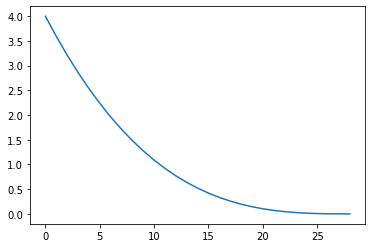

In [7]:
ind = comp.indicator['safety_factor']

sf = ind._safety_factor(
    agd = ind.component.indicator['external_diameter'].perfect,
    czd = ind.component.indicator['external_diameter'].get_condition_profile(200),
    wt = ind.component.indicator['wall_thickness'].get_condition_profile(200),
    margin = 4
)

plt.plot(sf)

In [11]:
df = comp.expected_risk_cost_df(t_end=200)

TypeError: replace expected at least 2 arguments, got 1

In [7]:
dash_id = 'FailureMode-fm-tasks-Task-inspection-active'
#value = False
#fm.update(dash_id, value)

comp.fm['fast_aging'].tasks['inspection'].t_interval=4

In [19]:
import numpy as np 
import math

task = comp.fm['slow_aging'].tasks['inspection']

t_stop = 100
t_delay=10

np.tile(
    np.linspace(5 - 1, 0, 5),
    math.ceil((t_stop - t_delay) / task.t_interval),
)

np.tile(
    np.arange(t_interval -1, 0, -1)
)

NameError: name 't_interval' is not defined

In [20]:
update_cost_fig(comp)

NameError: name 'update_cost_fig' is not defined

In [33]:
schedule = np.tile(
    np.linspace(self.t_interval - 1, 0, self.t_interval),
    math.ceil((t_stop - t_delay) / self.t_interval),
)

NameError: name 'np' is not defined

In [7]:
value = True
sep='-'
dash_id = 'FailureMode-fm-tasks-Task-inspection-active'
value = value / var_to_scale.get(dash_id.split(sep)[-1], 1)


# update the model
pof_obj.update(dash_id, value)
# Simulate an outcome
local = copy.deepcopy(pof_obj)
local.mc_timeline(t_end=200, n_iterations=100)
df = local.expected_risk_cost_df(t_end=200)

fig = px.area(
    df,
    x="time",
    y="cost_cumulative",
    color="task",
    #line_group='failure_mode',
    title="Maintenance Strategy Costs",
)

fig.show()

Invalid ID
100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


In [14]:
dash_id = 'FailureMode-fm-Distribution-untreated-beta'
value = 99
fm.update(dash_id, value)

fm.untreated.gamma

100

In [46]:
dash_id = 'failure_mode-fm'
sep='-'

obj = fm

# Remove the class type and class name from the dash_id
dash_id = dash_id.replace('failure_mode' + sep, '').replace(obj.name + sep, '')
var = dash_id.split(sep)[0]

# Check if the variable is an attribute of the class
if var in obj.__dict__:

    # Check if the variable is a dictionary
    if isinstance(obj.__dict__[var], dict): 
        key = dash_id.split(sep)[1]

        # Check if the variable is a class with its own dash methods
        if isinstance(obj.__dict__[var][key], (Component, Condition, Distribution, Consequence)):
                val = get_dash_id_value(obj.__dict__[var][key], dash_id)
        else:
            val = obj.__dict__[var][key]
    else:
        val = obj.__dict__[var]
else:
    val = ("Invalid id \"%s\" %s not in class" %(dash_id, var))



In [47]:
val

'Invalid id "conditions-wall_thickness" conditions not in class'

In [13]:
local = copy.deepcopy(fm)
local.mc_timeline(t_end=200, n_iterations=100)
df = local.expected_risk_cost_df()

fig = px.area(
    df,
    x="time",
    y="cost_cumulative",
    color="task",
    #line_group='failure_mode',
    title="Maintenance Strategy Costs",
)
fig.show()

100%|██████████| 100/100 [00:01<00:00, 58.39it/s]


In [8]:
df

,time,cost,cost_cumulative
task,,,
inspection,0,0,0
inspection,1,0,0
inspection,2,0,0
inspection,3,0,0
inspection,4,0,0
...,...,...,...
risk,196,0,0
risk,197,0,0
risk,198,0,0


In [9]:
# Testing to find the problem with the 
comp.expected_risk_cost_df(t_end=200).groupby(by=['failure_mode', 'task']).sum()

time  cost  cost_cumulative
failure_mode task                                             
fast_aging   cm                   20100     0                0
             inspection           20100     0                0
             on_condition_repair  20100     0                0
             risk                 20100     0                0
random       cm                   20100     0                0
             inspection           20100     0                0
             on_condition_repair  20100     0                0
             risk                 20100     0                0
slow_aging   cm                   20100     0                0
             inspection           20100     0                0
             on_condition_repair  20100     0                0
             risk                 20100     0                0

In [10]:
for fm in comp.fm.values():
    fm.cof.risk_cost_total = 10000

In [11]:
def update_maintenance_strategy():

    fm.mc_timeline(t_end=200, n_iterations=100)
    df = fm.expected_risk_cost_df()

    fig = px.area(
        df,
        x="time",
        y="cost_cumulative",
        color="task",
        #line_group='failure_mode',
        title="Maintenance Strategy Costs",
    )

    return fig

update_maintenance_strategy().show()

100%|██████████| 100/100 [00:01<00:00, 69.61it/s]


In [12]:
rc = fm.expected_risk_cost()



40.5 µs ± 8.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
df = comp.expected_risk_cost_df(t_end=200)
df.set_index(['failure_mode', 'task']).loc[['slow_aging', 'inspection']].head(10)

time cost cost_cumulative
failure_mode task                                
slow_aging   inspection    0    0               0
             inspection    1    0               0
             inspection    2    0               0
             inspection    3    0               0
             inspection    4    0               0
             inspection    5    0               0
             inspection    6    0               0
             inspection    7    0               0
             inspection    8    0               0
             inspection    9    0               0

In [8]:
dash_id = 'task-inspection-active'
dash_id = dash_id.replace(next_id + sep, "")
task_name= dash_id.split(sep)[0]
dash_id = dash_id.replace(next_id + sep, "")
dash_id

'inspection-active'

In [13]:
task.active

False